# HSE 2021: Mathematical Methods for Data Analysis

## Seminar 5: Classification metrics

**Authors**: Polina Polunina, Andrey Shestakov



## Today:
* Iris 2-class classification with logistic regression
* Classification metrics
* Data imbalance handling

#### Import packages:

In [ ]:
#linear algebra
import numpy as np
#data structures
import pandas as pd
#ml models
import scipy as sp
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import accuracy_score
#plots
import matplotlib.pyplot as plt
%matplotlib inline
#beautiful plots
import seaborn as sns
#linear regression
import statsmodels.api as sm
#set style for plots
sns.set_style('darkgrid')
#off the warnings
import warnings
warnings.filterwarnings("ignore")

#### Load the dataset:

In [ ]:
X, Y = sklearn.datasets.load_iris(return_X_y=True)
names = ['sepal length', 'sepal width', 'petal length', 'petal width']
classes = ['setosa', 'versicolor', 'virginica']

#create pandas data structure
data = pd.concat([pd.DataFrame(X, columns=names), pd.DataFrame(Y, columns=['target'])], axis=1)
data.head()

#### Target variable is already encoded:
    * 0 - Setosa
    * 1 - Versicolor
    * 2 - Verginica
    
<img src="https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Machine+Learning+R/iris-machinelearning.png" width=70%>

We will start from binary classification problem, for this purposes we will built a model to **classify Versicolor and Verginica** flowers

Let's cut Setosa from the data and change target variable values so that :
* Versicolor encoded as 0
* Virginica encoded as 1

In [ ]:
dt = data[data.target != 0]
dt.target = dt.target - 1
dt.head()

#### Data statistics:

In [ ]:
dt.describe()

In [ ]:
for name in names:
    dt[name].hist(bins=9, label=name)
    plt.legend()
    plt.show()

#### Correlation:

In [ ]:
sns.set(style="white")

# Compute the correlation matrix
corr = dt.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

#### Another nice plots:

In [ ]:
#where correlation is best?

In [ ]:
sns.pairplot(dt, kind='scatter', hue='target')
plt.show()

In [ ]:
sns.violinplot( x=dt["target"], y=dt["sepal length"])
plt.show()

#### Check rank of the features matrix:

In [ ]:
np.linalg.matrix_rank(dt.drop('target', axis=1))

#### Logistic Regression Model

In [ ]:
#from sklearn import metrics 
logit = sm.Logit((dt.target).values, dt.drop('target', axis=1))
result = logit.fit()
preds=result.predict(dt.drop('target', axis=1)).values

preds_classes = np.ones(preds.shape[0])
preds_classes[preds<0.5] = 0

# calculate accuracy
accuracy_score(dt.target, preds_classes)

#### Question: what is the difference between L1 and L2 regularization?

**Logistic regression with L1 regularization**

In [ ]:
from sklearn import linear_model
model=sklearn.linear_model.LogisticRegression(penalty='l1', solver='liblinear').fit(dt.drop('target', axis=1), dt.target)
preds=model.predict(dt.drop('target', axis=1))
accuracy_score(dt.target, preds)

**Logistic regression with L2 regularization**

In [ ]:
from sklearn import linear_model
model=sklearn.linear_model.LogisticRegression(penalty='l2').fit(dt.drop('target', axis=1), dt.target)
preds=model.predict(dt.drop('target', axis=1))
accuracy_score(dt.target, preds)

https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions

In [ ]:
solvers = ['newton-cg', 'sag', 'saga', 'lbfgs']
for solver in solvers:
    model = sklearn.linear_model.LogisticRegression(
        penalty='l2', solver=solver, fit_intercept=True
    ).fit(dt.drop('target', axis=1), dt.target)
    
    preds = model.predict(dt.drop('target', axis=1))
    preds_proba = model.predict_proba(dt.drop('target', axis=1))
    print(solver, accuracy_score(dt.target, preds))

### Plot pairvise decision boundaries

In [ ]:
def plot_decision_boundaries(feature_1, feature_2):
    # create meshgrid
    xx, yy = np.mgrid[feature_1.min():feature_1.max():.01, feature_2.min():feature_2.max():.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # set up and fit the model
    model = sklearn.linear_model.LogisticRegression().fit(dt[[feature_1.name, feature_2.name]], dt.target)
    probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)
    
    # make plots
    f, ax = plt.subplots(figsize=(15, 6))
    contour = ax.contourf(xx, yy, probs, 200, cmap="RdBu")
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")

    ax.scatter(feature_1, feature_2, c=dt.target, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

    ax.set(aspect="equal",
       xlim=(feature_1.min(), feature_1.max()), ylim=(feature_2.min(), feature_2.max()),
       xlabel=str(feature_1.name), ylabel=str(feature_2.name))

In [ ]:
for i in range(dt.shape[1]-2):
    plot_decision_boundaries(dt.iloc[:, i], dt.iloc[:, i+1])

### Analysing the results

As we can see, logreg with L2 regularization has the best accuracy score 0.97.

But, what accuracy score actualy mean?

## Classification metrics: confusion matrix

<img src="https://image.jimcdn.com/app/cms/image/transf/dimension=1920x10000:format=png/path/s8ff3310143614e07/image/iab2d53abc26a2bc7/version/1549760945/image.png" width=120%>

**Accuracy score** - is a ratio of accurately classified data points.

In [ ]:
(preds == dt.target).sum() / dt.target.shape[0]

In [ ]:
def my_accuracy_score(y_true, y_pred):
    my_acc = (y_true==y_pred).sum() / y_true.shape[0]
    return my_acc

In [ ]:
my_accuracy_score(dt.target, preds)

* **Prevalence** - a ratio of class 1 objects among all objects

In [ ]:
# your code goes here

In [ ]:
prevalence = dt.target.sum() / dt.target.shape[0]
prevalence

* **True positives** - a number of correctly classified objects of class 1

In [ ]:
tp = ((preds == 1) * (dt.target == 1)).sum()
tp

* **True negatives** - a number of correctly classified objects of class 0

In [ ]:
tn = ((preds == 0) * (dt.target == 0)).sum()
tn

* **False positives** - a number of wrongly classified objects of class 0, i.e. objects are classified as class 1 while actually belong to class 0 

In [ ]:
# your code goes here

In [ ]:
fp = ((preds == 1) * (dt.target == 0)).sum()
fp

* **False negatives** - a number of wrongly classified objects of class 1, i.e. objects are classified as class 0 while actually belong to class 0 

In [ ]:
# your code goes here

In [ ]:
fn = ((preds == 0) * (dt.target == 1)).sum()
fn

* **Condition Positive** - a number of objects that actually belong to class 1

In [ ]:
# your code goes here

In [ ]:
condition_positive = (dt.target == 1).sum()
condition_positive

* **Condition Negative** - a number of objects that actually belong to class 0

In [ ]:
# your code goes here

In [ ]:
condition_negative = (dt.target == 1).sum()
condition_negative

* **Predicted Condition Positive** - a number of objects that is predicted to belong to class 1

In [ ]:
# your code goes here

In [ ]:
predicted_cp = (preds==1).sum()
predicted_cp

* **Predicted Condition Negative** - a number of objects that is predicted to belong to class 0

In [ ]:
# your code goes here

In [ ]:
predicted_cn = (preds==0).sum()
predicted_cn

* **TPR** (the same as) **True Positive Rate** (the same as) **Recall** (the same as) **Sensitivity** (the same as) **Probability of detection** - a ratio of correctly classified class 1 objects among all class 1 objects

In [ ]:
# your code goes here

In [ ]:
tpr = tp / condition_positive
tpr

* **TNR** (the same as) **True Negative Rate** (the same as) **Specificity** (the same as) **Selectivity** - a ratio of correctly classified class 0 objects among all class 0 objects

In [ ]:
# your code goes here

In [ ]:
tnr = tn / condition_negative
tnr

* **FNR** (the same as) **False Negative Rate** (the same as) **Miss rate** - a ratio of wrongly classified class 1 objects among all class 1 objects

In [ ]:
# your code goes here

In [ ]:
fnr = fn / condition_positive
fnr

* **FPR** (the same as) **False Positive Rate** (the same as) **Fall-out** (the same as) **Probability of false alarm** - a ratio of wrongly classified class 0 objects among all class 0 objects

In [ ]:
# your code goes here

In [ ]:
fpr = fp / condition_negative
fpr

* **Precision** (the same as) **Positive Predictive Value** (the same as) **PPV** - a ratio of correctly classified class 1 objects among all predicted as class 1 objects

In [ ]:
# your code goes here

In [ ]:
precision = tp / predicted_cp
precision

* **NPV** (the same as) **Negative Predictive Value** - a ratio of correctly classified class 0 objects among all predicted as class 0 objects

In [ ]:
# your code goes here

In [ ]:
npv = tn / predicted_cn
npv

* **False Omission Rate** (the same as) **FOR** - a ratio of wrongly classified objects of class 1 among all predicted as class 0 objects

In [ ]:
# your code goes here

In [ ]:
fo_rate = fn / predicted_cn
fo_rate

* **False Discovery Rate** (the same as) **FDR** - a ratio of wrongly classified objects of class 0 among all predicted as class 1 objects

In [ ]:
# your code goes here

In [ ]:
fd_rate = fp / predicted_cp
fd_rate

* **Positive Likelihood Ratio** 

$$LR+ = \frac{TPR}{FPR}$$

In [ ]:
# your code goes here

In [ ]:
lr_positive = tpr / fpr
lr_positive

* **Negative Likelihood Ratio** 

$$LR- = \frac{FNR}{TNR}$$

In [ ]:
# your code goes here

In [ ]:
lr_negative = fnr / tnr
lr_negative

* **Diagnostic Odds Ratio** 

$$DOR = \frac{LR+}{LR-}$$

In [ ]:
# your code goes here

In [ ]:
dor = lr_positive / lr_negative
dor

* **F1 score** is a harmonic mean between **Precision** and **Recall** 

$$F_{1} score = 2\frac{Precision \cdot Recall}{Precision + Recall}$$

In [ ]:
# your code goes here

In [ ]:
f1_score = 2 * precision * tpr / (precision + tpr)
f1_score

In [ ]:
# check
sklearn.metrics.f1_score(dt.target, preds)

* **$F_{\beta}$ score** - a more general F score that uses a positive real factor β, where β is chosen such that recall is considered β times as important as precision

$$F_{\beta} score = (1 + \beta^2)\frac{Precision \cdot Recall}{\beta^2 Precision + Recall}$$

In [ ]:
# your code goes here

In [ ]:
def f_beta_score(beta, precision, recall):
    fb = (1 + beta**2) * precision * recall / (beta * beta * precision + recall)
    return fb

### ROC curve

* ROC curve - is a function TPR(FPR), it shows how the probability of correct classification on positive classes ("recognition rate") changes with probability of incorrect classification on negative classes ("false alarm"). 
* It is build as a set of points TPR($\mu$), FPR($\mu$).
* If $\mu \downarrow$ , the algorithm predicts $\omega_{1}$ more often and
    * TPR=$1-\varepsilon_{1}$ $\uparrow$
    * FPR=$\varepsilon_{2}$ $\uparrow$

* Characterizes classification accuracy for different $\mu$.
    * more concave ROC curves are better

* $TPR = \frac{TP}{TP + FN}=\frac{TP}{Pos}$
* $FPR = \frac{FP}{FP + TN} = \frac{FP}{Neg}$

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}

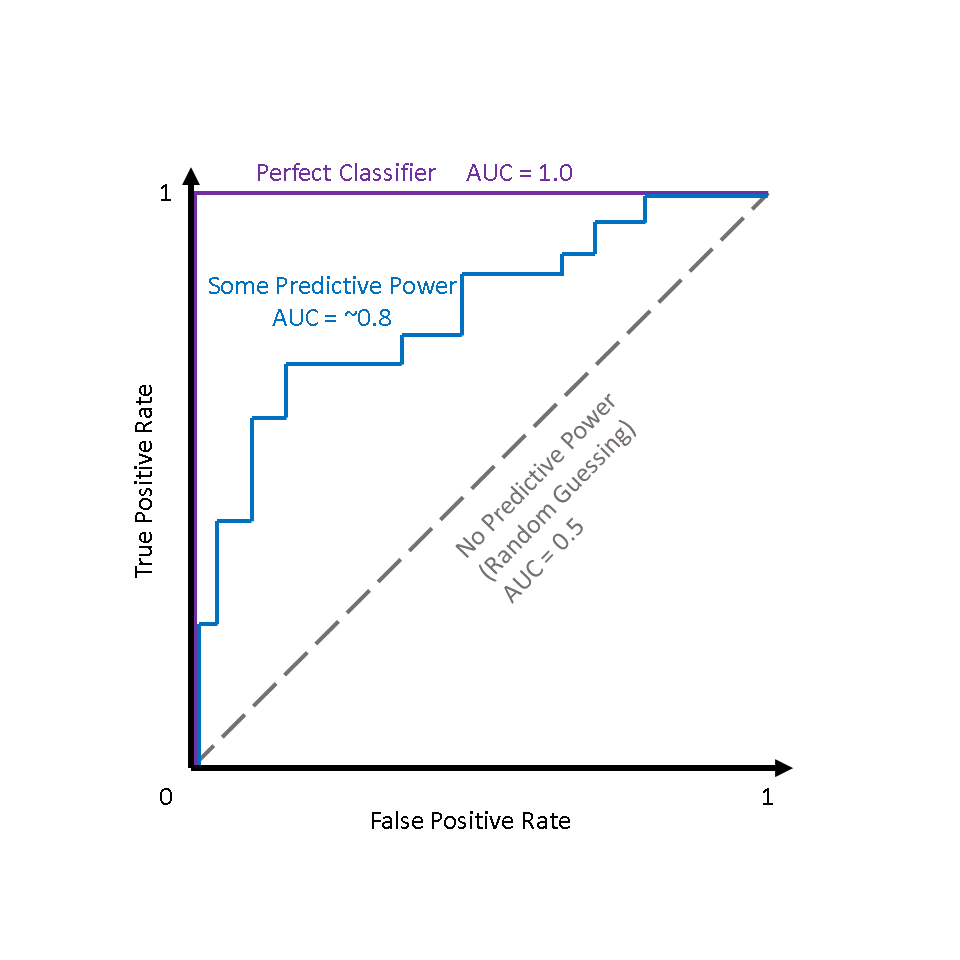

https://towardsdatascience.com/understanding-the-roc-curve-and-auc-dd4f9a192ecb

### ROC-AUC
* Area under the ROC curve

* Global quality characteristic for different $\mu$
* AUC$\in[0,1]$
    * AUC = 0.5 - equivalent to random guessing
    * AUC = 1 - no errors classification.

* AUC property: it is equal to probability that for 2 random objects $x_{1}\in \text{"+"}$ and $x_{2}\in \text{"-"}$ it will hold that: $\widehat{p}(+|x_{1})>\widehat{p}(+|x_2)$

* What about unbalanced case?

In [ ]:
sklearn.metrics.plot_roc_curve(model, dt.drop('target', axis=1), dt.target)  
plt.show()

In [ ]:
sklearn.metrics.roc_auc_score(dt.target, preds_proba[:, 1])

## Handling Imbalance in Data

A dataset is said to be **imbalanced** when there is a significant, or in some cases extreme, disproportion among the number of examples of each class

When this is the case, accuracy score is not an effective and indicative measure of model perfomance.

What we can do in this case?

* Make a dataset balanced
* Use more representative metrics (ROC_AUC, $F_\beta$ score, Recall, Specificity etc.)
* Give proportional weights to classes inside the model (it is possible for some sklearn models, gradient boosting and neural network libraries)  

Today we will learn how to make a dataset artificially balanced. There are a number of such a techniques:
    
* Under-sampling the majority class(es)
* Over-sampling the minority class
* Combining over- and under-sampling
* Create ensemble balanced sets

<a href="https://pypi.org/project/imbalanced-learn/">ImbLearn</a> - a library for resampling, contains a large number of SMOTE methods

In [ ]:
!pip install imblearn --user --quiet

In [ ]:
import imblearn

### Undersampling with NearMiss

In [ ]:
#Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
#License: MIT

from collections import Counter

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

print(__doc__)

RANDOM_STATE = 42

#Create a folder to fetch the dataset
iris = load_iris()
X, y = make_imbalance(
    iris.data,
    iris.target,
    sampling_strategy={0: 25, 1: 50, 2: 50},
    random_state=RANDOM_STATE,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

#Create a pipeline
pipeline = make_pipeline(
    NearMiss(version=2), StandardScaler(), LogisticRegression(random_state=RANDOM_STATE)
)
pipeline.fit(X_train, y_train)

#Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

### OverSampling with RandomOverSampler

In [ ]:
print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

#Create a pipeline
pipeline = make_pipeline(
    RandomOverSampler(), StandardScaler(), LogisticRegression(random_state=RANDOM_STATE)
)
pipeline.fit(X_train, y_train)

#Classify and report the results
print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))